正则化缓和过拟合

在损失函数中引入模型的复杂度指标，利用给w加权值，弱化了训练数据噪声的影响。

$$\text{loss} = \text{loss}(y, y\_) + \text{REGULARIZER}*\text{loss}(w)$$

 - L1正则化：
     $$\text{loss}_{L1}(w) = \sum\|w_i\|$$
     ```python
     loss(w) = tf.contrib.layer.l1_regularizer(REGULARIZER)(w)
     ```
 - L2正则化：
     $$\text{loss}_{L2}(w) = \sum\|w_i^2\|$$
     ```python
     loss(w) = tf.contrib.layer.l2_regularizer(REGULARIZER)(w)
     ```

```python
tf.add_to_collection("losses", tf.contrib.layer.l2_regularizer(regularizer)(w))  # 将参数w的L2正则加入集合losses中
loss = ce_loss + tf.add_n(tf.get_collection("losses)))  # 将集合losses中所有的项相加
```

#### 1 - 生成数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

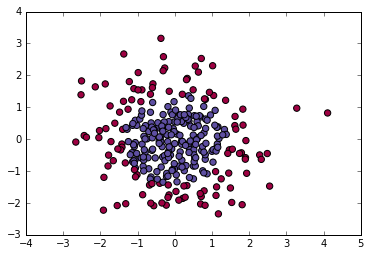

In [2]:
rdm = np.random.RandomState(2)
X = rdm.randn(300, 2)
Y = [[int(x0*x0 + x1*x1 < 2)] for (x0, x1) in X]
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral, s=40)
plt.show()

In [3]:
BATCH_SIZE = 30

def get_weight(shape, regularizer):
    w = tf.Variable(tf.random_normal(shape), tf.float32)
    tf.add_to_collection("losses", tf.contrib.layers.l2_regularizer(regularizer)(w))
    return w

def get_bias(shape):
    b = tf.Variable(tf.constant(0.01, shape=shape))
    return b

#### 1 - 无正则化

Instructions for updating:
Use the retry module or similar alternatives.
After    0 steps, loss is 5.389894
After 4000 steps, loss is 0.694411
After 8000 steps, loss is 0.210681
After 12000 steps, loss is 0.096851
After 16000 steps, loss is 0.078067
After 20000 steps, loss is 0.073013
After 24000 steps, loss is 0.071610
After 28000 steps, loss is 0.071031
After 32000 steps, loss is 0.070457
After 36000 steps, loss is 0.069931


D:\soft\Ana\lib\site-packages\numpy\ma\core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
D:\soft\Ana\lib\site-packages\numpy\ma\core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


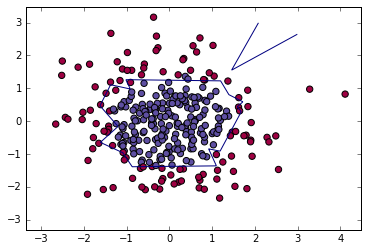

In [4]:
x = tf.placeholder(tf.float32, shape=(None, 2))
y = tf.placeholder(tf.float32, shape=(None, 1))

w1 = get_weight([2, 11], 0.01)
b1 = get_bias([11])
w2 = get_weight([11, 1], 0.01)
b2 = get_bias([1])

a = tf.nn.relu(tf.matmul(x, w1) + b1)
y_hat = tf.matmul(a, w2) + b2

loss_mse = tf.reduce_mean(tf.square(y_hat - y))
loss_regularizer = loss_mse + tf.add_n(tf.get_collection("losses"))

train = tf.train.AdamOptimizer(0.0001).minimize(loss_mse)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(40000):
        start = (i * BATCH_SIZE) % 300
        end = start + BATCH_SIZE
        sess.run(train, feed_dict={x: X[start:end], y:Y[start:end]})
        if i % 4000 == 0:
            print("After %4d steps, loss is %f" % (i, sess.run(loss_mse, feed_dict={x: X, y:Y})))
            
    xx, yy = np.mgrid[-3:3:0.01, -3:3:0.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = sess.run(y_hat, feed_dict={x:grid})
    probs = probs.reshape(xx.shape)

plt.scatter(X[:,0], X[:,1], c=Y, cmap=plt.cm.Spectral, s=40)
plt.contour(xx, yy, probs, levels=[0.5])
plt.show()

#### 2 - 加正则的loss

After 0 steps, loss is 9.443471
After 4000 steps, loss is 0.453037
After 8000 steps, loss is 0.202891
After 12000 steps, loss is 0.159442
After 16000 steps, loss is 0.137440
After 20000 steps, loss is 0.121870
After 24000 steps, loss is 0.109973
After 28000 steps, loss is 0.103687
After 32000 steps, loss is 0.099956
After 36000 steps, loss is 0.098316


D:\soft\Ana\lib\site-packages\numpy\ma\core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
D:\soft\Ana\lib\site-packages\numpy\ma\core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


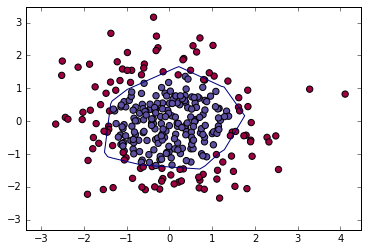

In [5]:
train_r = tf.train.AdamOptimizer(0.0001).minimize(loss_regularizer)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(40000):
        start = (i * BATCH_SIZE) % 300
        end = start + BATCH_SIZE
        sess.run(train_r, feed_dict={x:X[start:end], y:Y[start:end]})
        if i % 4000 == 0:
            print("After %d steps, loss is %f" % (i, sess.run(loss_regularizer, feed_dict={x:X, y:Y})))
    
    xx, yy = np.mgrid[-3:3:0.01, -3:3:0.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = sess.run(y_hat, feed_dict={x:grid})
    probs = probs.reshape(xx.shape)

plt.scatter(X[:,0], X[:,1], c=Y, cmap=plt.cm.Spectral, s=40)
plt.contour(xx, yy, probs, levels=[0.5])
plt.show()